# Run Training

In [1]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
print("Run at:", dt_string)

Run at: 30.05.2024 10:01:28


In [2]:
# Enable interactive plot
#@formatter:off
%matplotlib inline
%load_ext autoreload
%autoreload 2
#@formatter:on

import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from run import path_resolution
import importlib

/Users/yale/miniconda3_x86/envs/smart-cities/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
debug = False
num_worker = 20
computease = False

SAMPLE_RATE = 30.0
plot_length = int(SAMPLE_RATE * 20) # ie one minute

data = "RSO_LModule"

# path resolution
base_path = path_resolution()

Base path: /Users/yale/Repositories/etap/smart-cities-journal-based-on-jonahs-ma/data/


# Load Data

In [4]:
# construct data module
DLModule = getattr(importlib.import_module(f"datasets.{data}"), data)
data_module = DLModule(data_dir=base_path, 
    n_jobs=num_worker, 
    debug=debug, 
    batch_size=1,
    fix_nan=True)

all_datasets = data_module._load_datasets(sessions=[1, 2])
all_optitrack_data = pd.concat([d.optitrack_data.assign(Session=i+1) for i, d in enumerate(all_datasets)])

QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1141.62it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:10<00:00,  5.44s/it]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 22192.08it/s]


In [5]:
all_optitrack_data

Ab                              Chest                          \
        Position                           Position                           
Frame          X           Y           Z          X           Y           Z   
0      34.911232  102.498116   16.107584  35.102566  117.664268   18.061092   
1      34.911255  102.495071   16.100935  35.107567  117.658165   18.054359   
2      34.909985  102.494904   16.090366  35.108509  117.658875   18.037148   
3      34.906654  102.494957   16.074156  35.108437  117.658401   18.013845   
4      34.904053  102.495766   16.053795  35.104115  117.659447   17.983305   
...          ...         ...         ...        ...         ...         ...   
26694 -61.753910   98.954926  159.227478 -64.095428  113.793991  157.566711   
26695 -60.515415   98.996063  161.255127 -63.186329  113.908424  159.952408   
26696 -59.448601   99.339859  163.086899 -62.126595  114.169312  162.096649   
26697 -58.534668   99.440704  164.697632 -61.073845  114.272964  164.093262   
26698 -57.588608   99.344719  166.172104 -60.083874  114.278938  165.789215   

            Head                                Hip  ...     RThigh  \
        Position                           Position  ...   Position   
Frame          X           Y           Z          X  ...          X   
0      34.254826  147.644104   15.279250  34.697842  ...  43.865959   
1      34.251488  147.640305   15.268892  34.697655  ...  43.865757   
2      34.243488  147.634247   15.236509  34.696449  ...  43.864536   
3      34.242786  147.629715   15.194829  34.692921  ...  43.860931   
4      34.227776  147.625946   15.145537  34.689236  ...  43.857185   
...          ...         ...         ...        ...  ...        ...   
26694 -60.523384  144.071060  158.221863 -61.941551  ... -69.820206   
26695 -59.966217  144.277710  160.548309 -60.712082  ... -68.292854   
26696 -59.135563  144.506454  162.965485 -59.687828  ... -66.964958   
26697 -58.051098  144.528442  165.183701 -58.766701  ... -65.729889   
26698 -56.845592  144.548630  167.022934 -57.891624  ... -64.552727   

                                   RToe                            RUArm  \
                               Position                         Position   
Frame          Y           Z          X         Y           Z          X   
0      94.707199   16.072893  50.566929  4.496662   14.127948  54.588383   
1      94.703903   16.067360  50.564671  4.498981   14.126810  54.595005   
2      94.703789   16.058727  50.565918  4.498118   14.127122  54.599728   
3      94.703514   16.041416  50.564911  4.497473   14.125580  54.606785   
4      94.702995   16.025818  50.565292  4.495665   14.126169  54.610489   
...          ...         ...        ...       ...         ...        ...   
26694  91.574074  163.847488 -59.179794  4.574925  185.943329 -83.210335   
26695  91.582222  166.298248 -59.378223  4.198625  186.817566 -82.254143   
26696  91.945137  168.537491 -59.211517  3.933679  186.794968 -80.925323   
26697  92.049400  170.569946 -59.072578  3.860830  186.741165 -79.319595   
26698  91.983513  172.352737 -58.934898  3.898886  186.742264 -77.553131   

                              Session  
                                       
Frame           Y           Z          
0      133.739410   20.517035       1  
1      133.734116   20.504158       1  
2      133.731659   20.484558       1  
3      133.724533   20.458763       1  
4      133.721817   20.424810       1  
...           ...         ...     ...  
26694  129.099350  160.656006       2  
26695  128.932922  164.357590       2  
26696  128.927246  168.203094       2  
26697  128.903931  171.913208       2  
26698  128.865005  175.177017       2  

[52317 rows x 64 columns]

# Knee angle over time

In [6]:
# https://stackoverflow.com/a/13849249
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def calc_knee_angle(df, rl='R'):
    # Basically the info jonah noticed during his ma: the "bones" are actually also joints. e.g. the RShin is located at the knee joint...
    # TODO: double check
    # This then means, that the knee angle is simply the angle between the vector from Rshin to Rthigh and the vector from Rshin to Rfoot

    # calc vectors RShin -> RThigh and RShin -> RFoot
    rsrt = (all_optitrack_data[f'{rl}Shin'] - all_optitrack_data[f'{rl}Thigh']).to_numpy()
    rsrf = (all_optitrack_data[f'{rl}Shin'] - all_optitrack_data[f'{rl}Foot']).to_numpy()

    return 180 - np.rad2deg([angle_between(a, b) for a, b in zip(rsrt, rsrf)])

In [7]:
all_optitrack_data['Knee Angle R'] = calc_knee_angle(all_optitrack_data, 'R')
all_optitrack_data['Knee Angle L'] = calc_knee_angle(all_optitrack_data, 'L')

In [8]:
all_optitrack_data['Time [s]'] = np.round(all_optitrack_data.index / SAMPLE_RATE, 2)

/var/folders/md/yw20pthj1s32xxd99m5hmpcc0000gn/T/ipykernel_36211/1799654274.py:7: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  all_optitrack_data[all_optitrack_data.Session == ses].set_index('Time [s]')[['Knee Angle R', 'Knee Angle L']][:2000].plot(ax=axes[i])
/var/folders/md/yw20pthj1s32xxd99m5hmpcc0000gn/T/ipykernel_36211/1799654274.py:7: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  all_optitrack_data[all_optitrack_data.Session == ses].set_index('Time [s]')[['Knee Angle R', 'Knee Angle L']][:2000].plot(ax=axes[i])


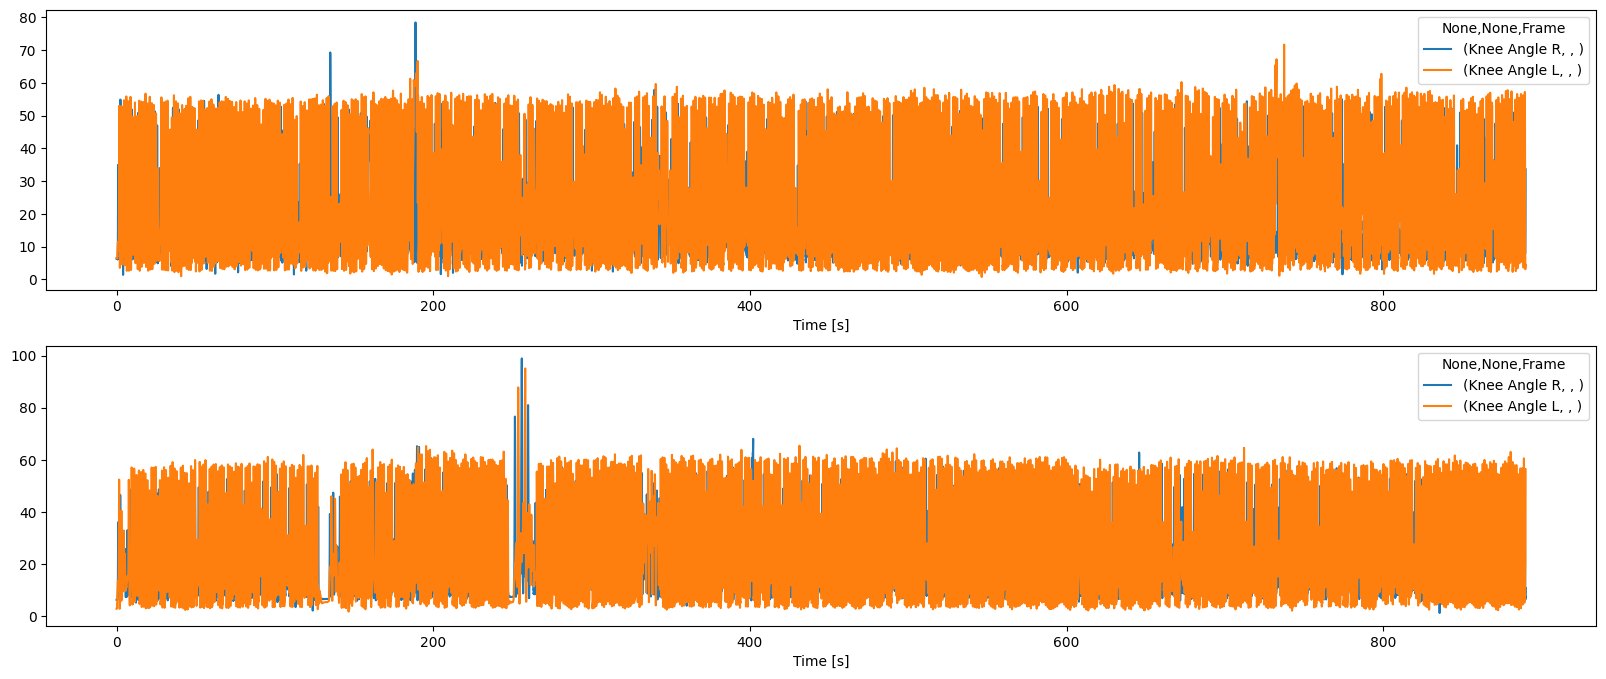

In [9]:
# todo: use seaborn facetgrid instead

sessions = list(all_optitrack_data['Session'].unique())
fig, axes = plt.subplots(nrows=len(sessions), ncols=1, figsize=(20, 4 * len(sessions)))

for i, ses in enumerate(sessions):
    all_optitrack_data[all_optitrack_data.Session == ses].set_index('Time [s]')[['Knee Angle R', 'Knee Angle L']][:2000].plot(ax=axes[i])

# Segmentation using TSSearch

<Axes: >

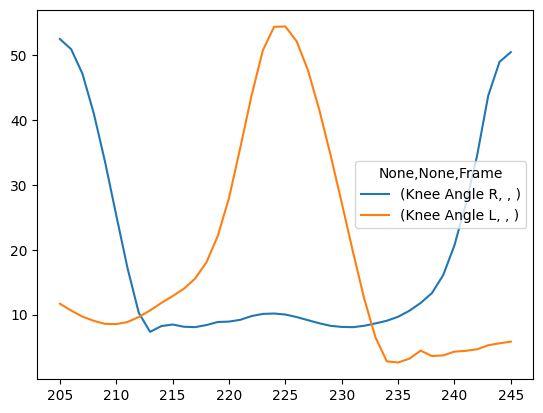

In [10]:
session = all_optitrack_data[['Knee Angle R', 'Knee Angle L']]
example = session[all_optitrack_data.Session == 1].loc[205:245].copy()
example.plot()

In [11]:
import tssearch

cfg = tssearch.get_distance_dict(["Dynamic Time Warping"])
out = tssearch.time_series_segmentation(cfg, example.to_numpy(), session.to_numpy())
out

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


{'Dynamic Time Warping': array([    7,    46,    71, ..., 52236, 52268, 52298])}

In [12]:
borders = np.zeros_like(session.to_numpy()[:, 0])
borders[out['Dynamic Time Warping']] = 1
all_optitrack_data['TSSearch Segmentation'] = borders

In [13]:
import matplotlib.pyplot as plt

def plot_borders(session, border_index, plot_length):
    plt.subplots(figsize=(20, 5))

    last_i = 0
    for j, i in enumerate(border_index):
        plt.axvspan(last_i, i, facecolor='0.2', alpha=0.1 + 0.1 * j % 0.5)
        last_i = i
        if i > plot_length:
            break

    plt.plot(session[:plot_length])

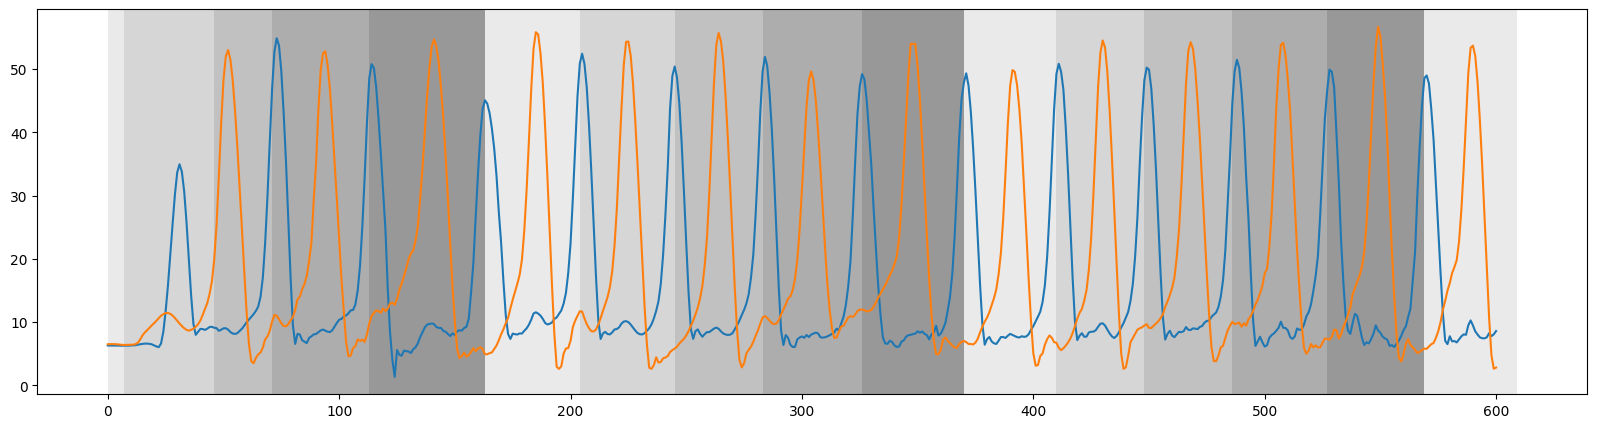

In [14]:
plot_borders(session, out['Dynamic Time Warping'], plot_length)

In [15]:
d = all_optitrack_data.reset_index().rename({'index': 'Frame'}, axis=1)[['Session', 'Frame', 'Time [s]', 'Knee Angle R', 'Knee Angle L', 'TSSearch Segmentation']]
d.columns = d.columns.droplevel(1).droplevel(1)
d.to_csv('gait_segmentation.csv', index=False)
d

,Session,Frame,Time [s],Knee Angle R,Knee Angle L,TSSearch Segmentation
0,1,0,0.00,6.319441,6.525071,0.0
1,1,1,0.03,6.308759,6.536931,0.0
2,1,2,0.07,6.311680,6.544276,0.0
3,1,3,0.10,6.315965,6.530778,0.0
4,1,4,0.13,6.307889,6.515657,0.0
...,...,...,...,...,...,...
52312,2,26694,889.80,6.891705,21.495904,0.0
52313,2,26695,889.83,7.908623,28.289645,0.0
52314,2,26696,889.87,9.271099,37.599510,0.0
52315,2,26697,889.90,10.230066,47.502917,0.0


# Agglomerative Clustering

In [16]:
# currently not working and i don't have the time to figure out why...

In [17]:
# def plot_segments(session, segments, plot_length):
#     plt.subplots(figsize=(20, 5))

#     last_i = 0
#     for j, i in enumerate(border_index):
#         plt.axvspan(last_i, i, facecolor='0.2', alpha=0.1 + 0.1 * j % 0.5)
#         last_i = i
#         if i > plot_length:
#             break

#     plt.plot(session[:plot_length])

In [18]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy import sparse
# from itertools import groupby

# def flatten_comprehension(matrix):
#     return [item for row in matrix for item in row]

# def create_connectivity(n_samples, n_neighbors=1, random_connections=0):
#     # basic example for left and right neighbours:
#     # should set the center diagonal as well as one upper and lower diagonal to 1
#     # i.e. each sample is connected to itself, the previous and the next sample
#     if n_neighbors < 1:
#         raise ValueError("n_neighbors must be at least 1 otherwise samples can only be merged with themselves")

#     # create a matrix with n_neighbors on each side connected
#     diagonal_idx = list(range(-n_neighbors, n_neighbors + 1))
#     x = np.ones((len(diagonal_idx), n_samples))
#     connected_neighbors = sparse.spdiags(x, diagonal_idx, n_samples, n_samples).tolil()

#     if random_connections > 0:
#         # add random connections
#         x, y = np.random.randint(0, n_samples, random_connections * 2).reshape((2, random_connections)).tolist()
#         # connect symetrically
#         connected_neighbors[x, y] = 1 
#         connected_neighbors[y, x] = 1

#     return connected_neighbors

# # sequence = np.asarray(all_optitrack_data[all_optitrack_data.session == 1].to_numpy())[:100]
# # sequence = np.diff(sequence, axis=0)
# sequence = np.asarray(session[all_optitrack_data.session == 1])[:200, :1]
# # sequence = np.diff(sequence, axis=0)
# connectivity = create_connectivity(sequence.shape[0], n_neighbors=1, random_connections=500)
# clst = AgglomerativeClustering(connectivity=connectivity, n_clusters=5)
# clst.fit(sequence)
# # borders = np.argwhere(np.diff(clst.labels_.copy()) > 0).flatten()
# borders, plot_segments(sequence, clst.labels_, plot_length)